In [1]:
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

import networkx as nx
from tqdm import tqdm
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

from karateclub import DeepWalk
from karateclub.dataset import GraphSetReader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Get and prepare data

In [ ]:
def chunkwise(t, size=2):
    it = iter(t)
    newzipped = zip(*[it]*size)
    newlist = [list(x) for x in newzipped]
    return newlist

def validation_sampler(sample_split, classpick=None):
    newbag = []
    loader = []
    if classpick:
        for c in classpick:
            for x,y in sample_split:
                if y==c:
                    newbag.append((x, y))
                    break
    else:
        newbag = sample_split
    for img, y in newbag:
        dataload = Data(
            img=img,
            y=torch.tensor(y)
        )
        loader.append(dataload)
    
    return loader

In [2]:
reddit_data = GraphSetReader("reddit10k") #  two types - discussion and non-discussion based ones.
protein_data = TUDataset(r'C:\Users\16sic\Documents\GitHub\conference_draft\src\\', r'PROTEINS')

NameError: name 'GraphSetReader' is not defined

In [36]:
protein_data = protein_data.shuffle()
get_all_edge = [data.edge_index for data in protein_data]
get_all_edget = [np.vstack((x,y)).T for x,y in get_all_edge]
protein_edgelist = []
for x in range(len(get_all_edget)):
    G = nx.Graph()
    G.add_edges_from(get_all_edget[x])
    newedgelist.append(G)
get_all_target = [data.y.item() for data in protein_data]

In [37]:
reddit_graphlist = reddit_data.get_graphs()[:100]
reddit_targetlist = reddit_data.get_target()[:100]

In [63]:
reddit_bag = [(x,y) for x,y in zip(reddit_graphlist, reddit_targetlist)][50:55]
protein_bag = [(x,y) for x,y in zip(newedgelist, get_all_target)][20:25]

In [64]:
loader = validation_sampler(np.vstack((reddit_bag, protein_bag)))
dataloader = DataLoader(loader, batch_size=1, shuffle=False)

c:\users\16sic\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


# Load model created from "Siamese Network + GCN with graph Data" script

In [65]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    def forward(self, output1, output2, label):
        output1 = torch.norm(output1)
        output2 = torch.norm(output2)
        
        euclidean_distance = torch.abs(output1 - output2)
        
        #euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

In [66]:
class SiameseNetwork_GCN(nn.Module):
    def __init__(self):
        super(SiameseNetwork_GCN, self).__init__()        
        self.conv1 = GCNConv(16, 64)
        self.conv2 = GCNConv(64, 64)
        self.conv3 = GCNConv(64, 64)
        self.lin = nn.Linear(64,2)

    def forward_once(self, x):
        G = x[0]
        edges = G.edges()
        edgelist = list(zip(*edges))
        col1 = list(edgelist[0])
        col2 = list(edgelist[1])
        edge_index = torch.tensor([col1, col2])
        
        model = DeepWalk(dimensions=16)
        model.fit(G)
        
        x_embed = model.get_embedding()
        x_embed = torch.from_numpy(x_embed)
        
        x = self.conv1(x_embed, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [67]:
model_name = './data/siamese_gcn.pth'
model = torch.load(model_name)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [68]:
class0 = [x for x,y in reddit_bag if y==0][0]
class1 = [x for x,y in reddit_bag if y==1][0]

In [69]:
model.eval()
loss_dist = []
for data in dataloader:
    sample1, sample2 = net([class0], data.img)
    output1 = torch.norm(sample1)
    output2 = torch.norm(sample2)
    class0_euc_score = torch.abs(output1 - output2)

    sample1, sample2 = net([class1], data.img)
    output1 = torch.norm(sample1)
    output2 = torch.norm(sample2)
    class1_euc_score = torch.abs(output1 - output2)
    
    meanloss = (class0_euc_score + class1_euc_score).sum()
    loss_dist.append(meanloss.item())

"In both the below plots of the loss values, you noticed a vertical line. These lines are an estimated threshold value for which we will determine a loss value is or is not an anomaly. In the loss distribution plot, if the value exceed (to the right) of the red line, we will consider that data as an anomaly. There is a blue line that represents a lower threshold (anything below) but is not relevant for this example of data." from https://benjoe.medium.com/anomaly-detection-using-pytorch-autoencoder-and-mnist-31c5c2186329

c:\users\16sic\appdata\local\programs\python\python37\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


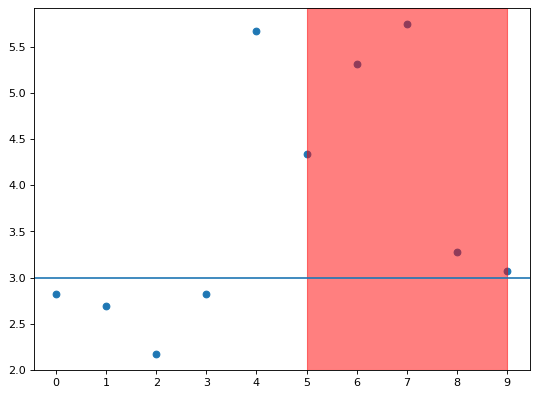

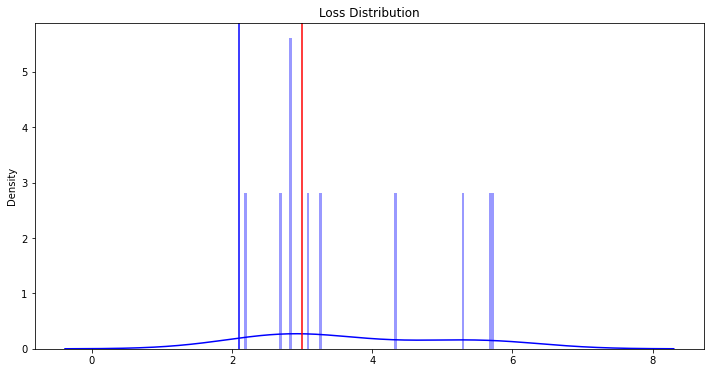

In [71]:
# Outlier threshold
plt.figure(figsize=(8, 6), dpi=80)
plt.axhline(3.0, 0.0, 1)
#plt.ylim(2.0,3.0)
plt.xticks([i for i in range(len(loader))])
plt.axvspan(len(reddit_bag), len(reddit_bag)+len(protein_bag)-1, color='red', alpha=0.5)

loss_sc = []
for i, x in enumerate(loss_dist):
    loss_sc.append((i,x))
plt.scatter(*zip(*loss_sc))

# loss distribution
lower_threshold = 2.1
upper_threshold = 3.0
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(loss_dist,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')